In [1]:
# import glob
# import math
import sys, os
sys.path.append('..')
sys.path.append('.')

import os.path
import shutil
import subprocess
import time

import tensorflow as tf
import ddsp
import ddsp.colab.colab_utils
import IPython
import matplotlib.pyplot as plt
import numpy as np
# import scipy.fft
import scipy.io
# import scipy.signal
import librosa
import pickle

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


(441344,)
44100

Extracting audio features...
stft_np is_2d:  True
audio before stft shape:  (1, 443328)
Computing loudness after stft shape:  (1, 6896, 1025)
power_db shape:  (1, 6896, 1025)
loudness shape:  (1, 6896, 1025)
shape of audio:  (1, 441344)
sample rate:  16000
n_secs:  27.584
expected length:  6896
shape of loudness before pad/trim:  (6896,)


/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/librosa/core/convert.py:1350: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


size of loudness vector:  (6896,)
List of all keys in audio features:  dict_keys(['audio', 'loudness_db', 'f0_hz', 'f0_confidence'])
Audio features took 7.0 seconds


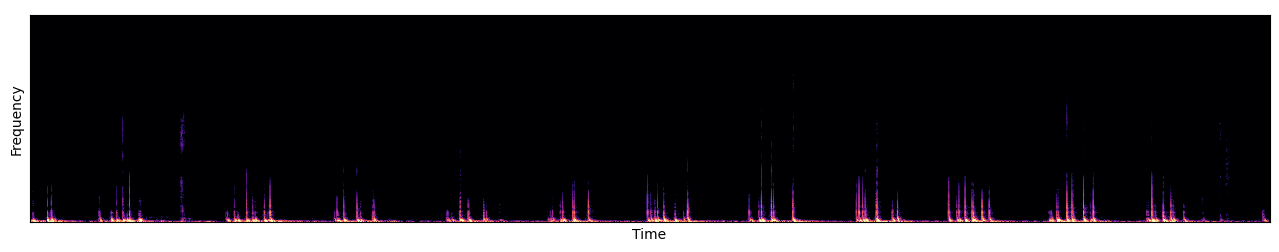

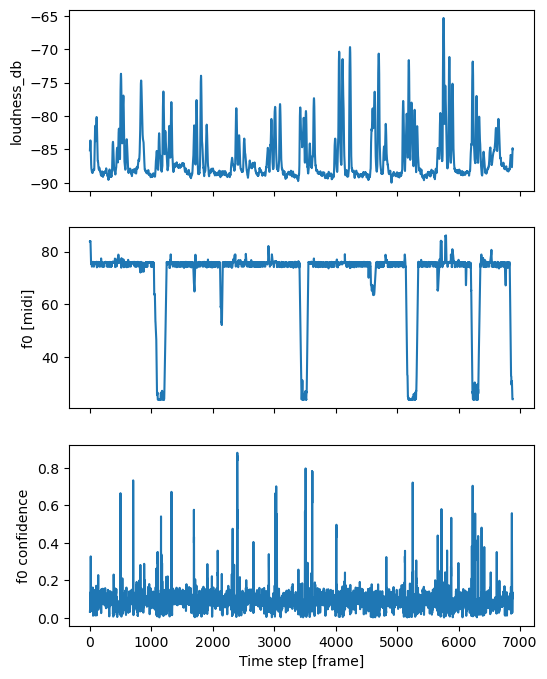

In [2]:
# Upload audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 
audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-360-of-365"
audio_file = f"/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav"
audios, sr = librosa.load(audio_file, sr=44100)
print(audios.shape)
print(sr)
#audio = audios[0]
audio = audios[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
ddsp.colab.colab_utils.specplot(audio)
#play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
print("size of loudness vector: ", audio_features['loudness_db'].shape)
audio_features_mod = None
print("List of all keys in audio features: ", audio_features.keys())
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')
plt.show()

import IPython.display as ipd
ipd.Audio(audio_file) # load a local WAV file

In [3]:
# Probably only want to run once
import gin
gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

sys.path.append('./ddsp')
sys.path.append('./ddsp/training/gin/')

In [4]:
#@title Load a model
#@markdown Run for ever new audio input
model = 'Violin' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
MODEL = model


def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 

if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = '/juno/u/jyau/regnet/ddsp/pretrained_models/violin_pretrained/'
  # Copy over from gs:// for faster loading.
  #!rm -r $PRETRAINED_DIR &> /dev/null
  #os.makedirs(PRETRAINED_DIR, exist_ok=True)
  #!mkdir $PRETRAINED_DIR &> /dev/null
  #GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2020-11-06'
  #GCS_CKPT_DIR = '/juno/u/jyau/regnet/ddsp/'
  # synthetic_pretrained_ckpt
  #model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  #model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  
  #!gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

else:
  # User models.
  UPLOAD_DIR = '/content/uploaded'
  #!mkdir $UPLOAD_DIR
  uploaded_files = files.upload()

  for fnames in uploaded_files.keys():
    print("Unzipping... {}".format(fnames))
    #!unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
  model_dir = find_model_dir(UPLOAD_DIR)
  gin_file = os.path.join(model_dir, 'operative_config-0.gin') # Log of all other gin files, use this to load existing checkpoint file


#gin_file = os.path.join('/juno/u/jyau/regnet/ddsp/ddsp/training/gin/models/ae.gin')
# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))

#gin_file = os.path.join('/juno/u/jyau/regnet/ddsp/ddsp/training/gin/models/ae.gin')
print("Gin file: ", gin_file)
#gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')
# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)
print("ckpt name: ", ckpt_name)

# Ensure dimensions and sampling rates are equal
#time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
#n_samples_train = gin.query_parameter('Additive.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

print("===Trained model===")
print("Time Steps", time_steps_train)
print("Samples", n_samples_train)
print("Hop Size", hop_size)
print("\n===Resynthesis===")
print("Time Steps", time_steps)
print("Samples", n_samples)
print('')

gin_params = [
    #'Additive.n_samples = {}'.format(n_samples),
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'DefaultPreprocessor.time_steps = {}'.format(time_steps),
    #'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from /juno/u/jyau/regnet/ddsp/pretrained_models/violin_pretrained/dataset_statistics.pkl
Gin file:  /juno/u/jyau/regnet/ddsp/pretrained_models/violin_pretrained/operative_config-0.gin
ckpt name:  ckpt-40000
===Trained model===
Time Steps 1000
Samples 64000
Hop Size 64

===Resynthesis===
Time Steps 6896
Samples 441344

Input to processor group:  dict_keys(['amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'f0_scaled', 'ld_scaled'])
In dag, inputs to run_dag:  dict_keys(['amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'f0_scaled', 'ld_scaled'])
Current output keys (will be used for next processor input):  dict_keys(['inputs', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'f0_scaled', 'ld_scaled'])
Necessary input_keys:  ListWrapper(['amps', 'harmonic_distribution', 'f0_hz'])
Size of frequency envelo


Skipping auto-adjust (no notes detected or ADJUST box empty).


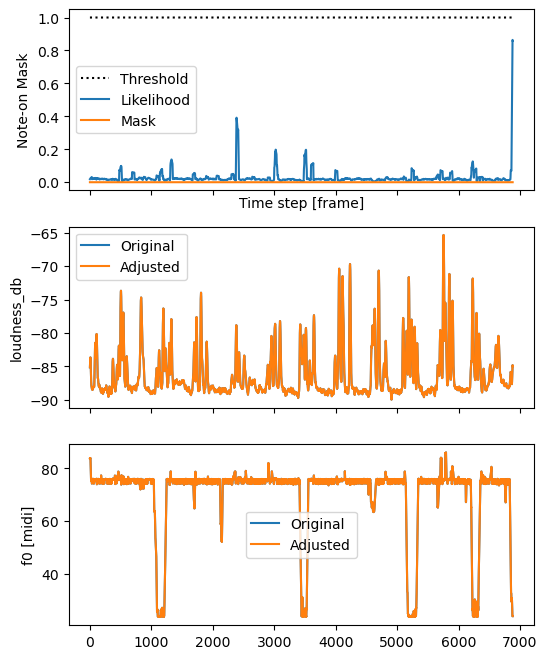

In [5]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjust the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform)
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])
plt.show()

Input to processor group:  dict_keys(['amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'f0_scaled', 'ld_scaled'])
In dag, inputs to run_dag:  dict_keys(['amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'f0_scaled', 'ld_scaled'])
Current output keys (will be used for next processor input):  dict_keys(['inputs', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'f0_scaled', 'ld_scaled'])
Necessary input_keys:  ListWrapper(['amps', 'harmonic_distribution', 'f0_hz'])
Size of frequency envelope:  (1, 6896, 60)
size of amplitude envelop:  (1, 6896, 60)
n_frames: 6897 and n_intervals: 6896
Size of frequency envelope:  (1, 441344, 60)
size of amplitude envelop:  (1, 441344, 60)
Current output keys (will be used for next processor input):  dict_keys(['inputs', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'audio', 'loudness_db', 

Resynthesis


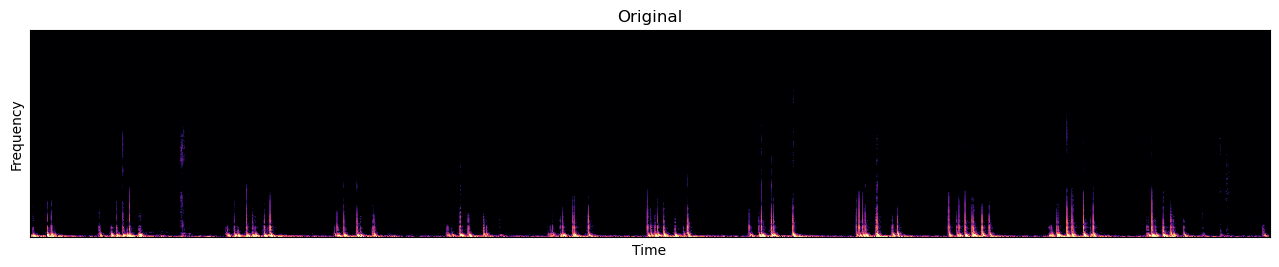

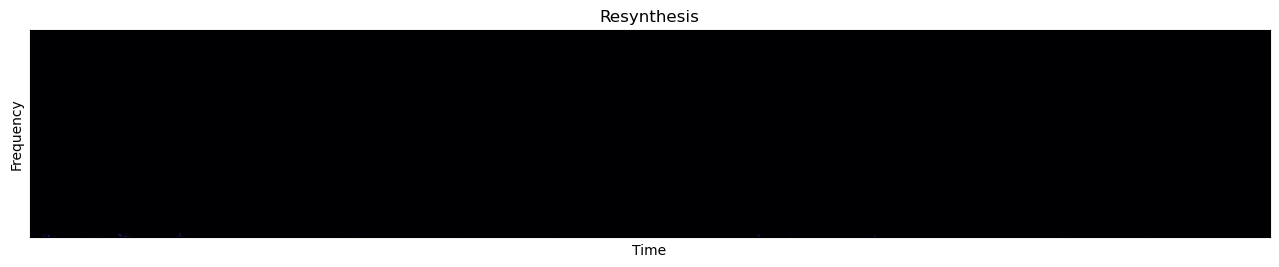

In [6]:
from IPython.display import display
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs) # returns outputs['audio_synth']
print('Prediction took %.1f seconds' % (time.time() - start_time))

os.makedirs('/juno/u/jyau/regnet/ddsp/pretrained_models/violin_pretrained/', exist_ok=True)
with open(f'/juno/u/jyau/regnet/ddsp/pretrained_models/violin_pretrained/{audio_title}.npy', 'wb') as f:
    np.save(f, audio_gen)

# Plot
print('Original')
#ddsp.colab.colab_utils.play(audio)
display(ipd.Audio(audio, rate=sr))

print('Resynthesis')
#ddsp.colab.colab_utils.play(audio_gen)
display(ipd.Audio(audio_gen, rate=sr))

ddsp.colab.colab_utils.specplot(audio)
plt.title("Original")

ddsp.colab.colab_utils.specplot(audio_gen)
_ = plt.title("Resynthesis")

plt.show()

(80, 1720)
Original audio shape:  (1, 138240)
sr of original audio:  44100

Extracting audio features...


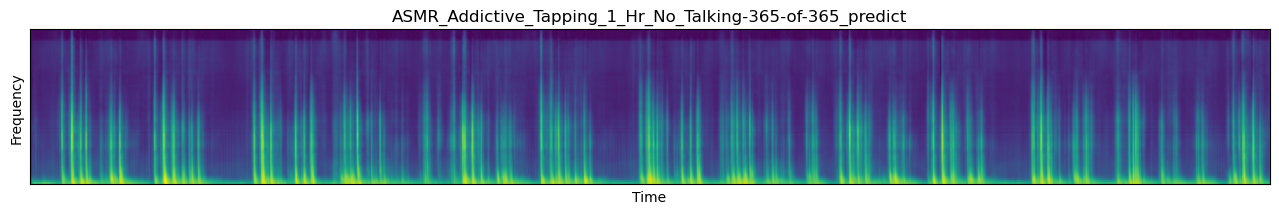

(1720, 80)
Original audio shape:  (1, 138240)
stft_np is_2d:  True
audio before stft shape:  (1, 140224)
ddsp author hop size:  64
overlap:  0.96875
Computing loudness after stft shape:  (1, 2160, 1025)
power_db shape:  (1, 2160, 1025)
loudness shape:  (1, 2160, 1025)
shape of audio:  (1, 138240)
sample rate:  16000
n_secs:  8.64
expected length:  2160
shape of loudness before pad/trim:  (2160,)


/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/librosa/core/convert.py:1350: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


Audio features took 1.7 seconds


In [6]:
MAX_WAV_VALUE = 32768.0

# Try loading in mel spectrogram instead of audio
audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-365-of-365"
audio_file = f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy"
audio = np.load(audio_file)
sr = 44100
print(audio.shape) # (num mel channels, time dimension)

# Original audio
audio_orig = f"/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav"
orig_audio, _ = librosa.load(audio_orig, sr=44100)
orig_audio = orig_audio[np.newaxis, :]
print("Original audio shape: ", orig_audio.shape)
print("sr of original audio: ", sr)

# Loading waveglow's output of the mel spectrogram
# orig_file = f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}_synthesis.wav"
# waveglow_audio, sr = librosa.load(orig_file)
# print(sr)

#audio = audios[0]
#audio = audios[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
ddsp.colab.colab_utils.specplot_mel_spec(audio, rotate=False)
#plt.show()

#play(audio)
plt.imshow(audio, aspect='auto', origin='lower')
plt.title(audio_title+"_predict")
#plt.figure(figsize=(40, 3))
#plt.tight_layout()
plt.show()
#plt.subplot(313)

# Setup the session.
#ddsp.spectral_ops.reset_crepe()

# Permute/transpose so time dimension is first
audio = np.transpose(audio)
print(audio.shape) # (time dimension, num mel channels)

# Compute features.
start_time = time.time()
print("Original audio shape: ", orig_audio.shape)
audio_features = ddsp.training.metrics.compute_audio_features(orig_audio)
#audio_features = ddsp.training.metrics.compute_audio_features_mel_spec(audio, orig_audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)

# Compute the frequency f0

audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))
#plt.show()

shape:  (1, 540, 513)
Squeezed shape:  (540, 513)


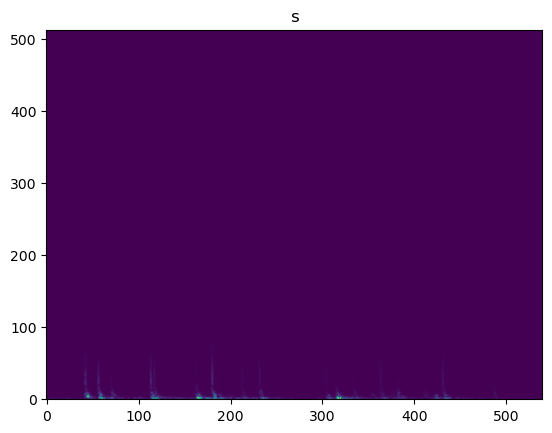

In [3]:
# Sanity check
#print("shape: ", audio_features['s'].shape)
#print("Values: ", audio_features['s'])
#print("abs values: ", np.abs(audio_features['s']))
#print("Squeezed shape: ", tf.squeeze(audio_features['s']).shape)

# Plot.
#ddsp.colab.colab_utils.specplot_mel_spec(np.abs(tf.squeeze(audio_features['s'])), rotate=False)
#plt.show()

#play(audio)
#plt.imshow(np.abs(tf.squeeze(audio_features['s'])).T, aspect='auto', origin='lower')
#plt.title("s")
#plt.figure(figsize=(40, 3))
#plt.tight_layout()
#plt.show()

In [3]:
# Probably only want to run once
import gin
gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

sys.path.append('./ddsp')
sys.path.append('./ddsp/training/gin/')

In [8]:
# Calculate frequency of mel spectrogram with unsupervised ResNet model

model_dir = '/juno/u/jyau/regnet/ddsp/pretrained_models/violin_pretrained/'
gin_file = os.path.join('/juno/u/jyau/regnet/ddsp/pretrained_models/resnet_sinusoidal/', 'operative_config-1.gin')
#gin_file = os.path.join('/juno/u/jyau/regnet/ddsp/ddsp/training/gin/models/ae.gin')
print("Gin file: ", gin_file)
#gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')
# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)
print("ckpt name: ", ckpt_name)

# Ensure dimensions and sampling rates are equal
#time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
#n_samples_train = gin.query_parameter('Additive.n_samples')
hop_size = int(n_samples_train / time_steps_train)
time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

print("===Trained model===")
print("Time Steps", time_steps_train)
print("Samples", n_samples_train)
print("Hop Size", hop_size)
print("\n===Resynthesis===")
print("Time Steps", time_steps)
print("Samples", n_samples)
print('')

gin_params = [
    #'Additive.n_samples = {}'.format(n_samples),
    'Harmonic.n_samples = {}'.format(n_samples),
    #'FilteredNoise.n_samples = {}'.format(1720),
    'DefaultPreprocessor.time_steps = {}'.format(time_steps),
    #'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
# for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
#   audio_features[key] = audio_features[key][:time_steps]
# audio_features['audio'] = audio_features['audio'][:, :n_samples]

# Original audio passing through compute_logmel
mel = ddsp.spectral_ops.compute_logmel(orig_audio, sample_rate=44100, bins=80, fft_size=1024)
print("mel shape: ", mel.shape)


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)
print("Finished setting up the model")

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Gin file:  /juno/u/jyau/regnet/ddsp/pretrained_models/resnet_sinusoidal/operative_config-1.gin
ckpt name:  ckpt-40000
===Trained model===
Time Steps 1000
Samples 64000
Hop Size 64

===Resynthesis===
Time Steps 1
Samples 64

Shape of mag from compute_mel:  (1, 540, 513)
mel shape:  (1, 540, 80)
Finished setting up the model
Shape of mag from compute_mel:  (1, 270, 1025)
Input to processor group:  dict_keys(['audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'frequencies', 'amplitudes', 'noise_magnitudes'])
In dag, inputs to run_dag:  dict_keys(['audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'frequencies', 'amplitudes', 'noise_magnitudes'])
Current output keys (will be used for next processor input):  dict_keys(['inputs', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'frequencies', 'amplitudes', 'noise_magnitudes'])
Necessary input_keys:  ListWrapper(['amplitudes', 'frequencies'])
Size of frequency envelope:  (1, 270, 100)
size of amplitude envelop:  (1, 270, 100)
n_frames: 271 and

key: audio and shape: (1, 138240)
key: loudness_db and shape: (2160,)
key: f0_hz and shape: (2160,)
key: f0_confidence and shape: (2160,)
Shape of mag from compute_mel:  (1, 270, 1025)
Input to processor group:  dict_keys(['audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'frequencies', 'amplitudes', 'noise_magnitudes'])
In dag, inputs to run_dag:  dict_keys(['audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'frequencies', 'amplitudes', 'noise_magnitudes'])
Current output keys (will be used for next processor input):  dict_keys(['inputs', 'audio', 'loudness_db', 'f0_hz', 'f0_confidence', 'frequencies', 'amplitudes', 'noise_magnitudes'])
Necessary input_keys:  ListWrapper(['amplitudes', 'frequencies'])
Size of frequency envelope:  (1, 270, 100)
size of amplitude envelop:  (1, 270, 100)
n_frames: 271 and n_intervals: 270
Size of frequency envelope:  (1, 138240, 100)
size of amplitude envelop:  (1, 138240, 100)
Current output keys (will be used for next processor input):  dict_keys(['inpu

Resynthesis


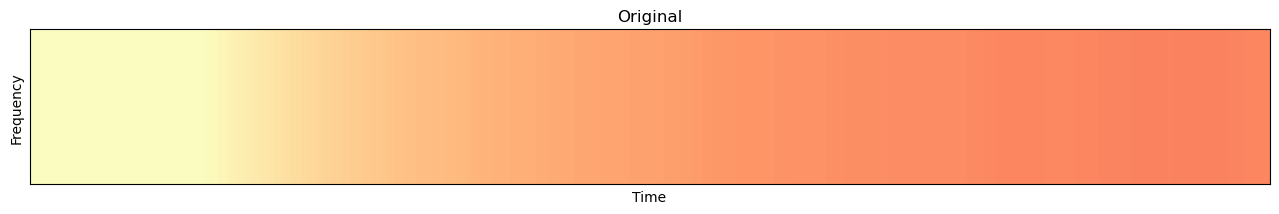

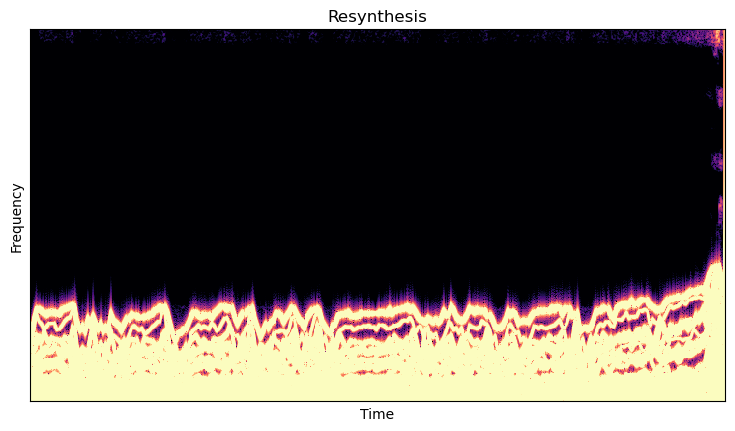

In [9]:
from IPython.display import display
import IPython.display as ipd
#@title #Resynthesize Audio

#audio_features['loudness_db'] = audio_features_test['loudness_db'].astype(np.float32)
af = audio_features if audio_features_mod is None else audio_features_mod
for key in audio_features:
    print(f"key: {key} and shape: {audio_features[key].shape}")

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs) # returns outputs['audio_synth']
print
print('Prediction took %.1f seconds' % (time.time() - start_time))
with open(f'/juno/u/jyau/regnet/ddsp/pretrained_models/resnet_sinusoidal/{audio_title}.npy', 'wb') as f:
    np.save(f, audio_gen)

# Mel spectrogram was created with waveglow processing
#audio_gen = audio_gen * MAX_WAV_VALUE

# Plot
print('Original')
#ddsp.colab.colab_utils.play(audio)
display(ipd.Audio(audio, rate=sr))

print('Resynthesis')
#ddsp.colab.colab_utils.play(audio_gen)
display(ipd.Audio(audio_gen, rate=sr))

ddsp.colab.colab_utils.specplot(audio, rotate=False)
plt.title("Original")

ddsp.colab.colab_utils.specplot(audio_gen)
_ = plt.title("Resynthesis")

plt.show()

In [2]:
data_dir = 'data/hammer'
source_files = ['ceramic.wav', 'polycarb.wav', 'steel.wav', 'wood.wav']
clips = []
forces = []
for f in source_files:
    fs, clip = scipy.io.wavfile.read(os.path.join(data_dir, f))
    offset = 0.15
    length = 3.0
    clip = clip[int(fs*offset):int(fs*(offset+length)), :]
    force = clip[:, 1]
    clip = clip[:, 0]
#     sos = scipy.signal.butter(10, 50, 'hp', fs=fs, output='sos')
#     clip = scipy.signal.sosfiltfilt(sos, clip)
    # Normalize
    clip = clip - np.mean(clip)
    clip = clip / np.max(np.abs(clip))
    clips.append(clip)
    forces.append(force)
clips = np.array(clips, dtype=np.float32)
forces = np.array(forces, dtype=np.float32)
# Sample first recording
IPython.display.Audio(data=clips[0, :], rate=fs)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Initialize modules, with internal sampling rate 2x the original recording sample rate
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(fs*sample_factor/1.0), sample_rate=int(fs*sample_factor),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(fs*sample_factor), n_samples=int(clip.shape[0]*sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

In [5]:
# Initialize all variables to optimize
tf.random.set_seed(0)
# Impact profile variables
# Discretize time into frame rate of 100 for impact predictions
discretization_frame_rate = 100
abbrev_length = int(discretization_frame_rate * (clips.shape[1]/fs))
mags = tf.Variable(tf.zeros((clips.shape[0], abbrev_length, 1)), dtype=tf.float32)
stdevs = tf.Variable(0.1 * tf.ones((clips.shape[0], abbrev_length, 1)), dtype=tf.float32)
taus = tf.Variable(tf.zeros((clips.shape[0], abbrev_length, 1)), dtype=tf.float32)

# Time-constant noise variables
noise_magnitudes = tf.Variable(tf.zeros((clips.shape[0], 200), dtype=tf.float32))

# Modal FIR variables
num_frequencies = 256
frequencies = tf.Variable(tf.random.normal((clips.shape[0], 1, num_frequencies,)), dtype=tf.float32)
dampings = tf.Variable(tf.random.normal((clips.shape[0], 1, num_frequencies,)), dtype=tf.float32)
gains = tf.Variable(tf.random.normal((clips.shape[0], 1, num_frequencies,)), dtype=tf.float32)

# Reverb variables
reverb_gains = tf.Variable(-1.0 + tf.zeros((clips.shape[0], 1, 32)), dtype=tf.float32)
reverb_decay = tf.Variable(3.0 + tf.zeros((clips.shape[0], 1, 32)), dtype=tf.float32)

# Acceleration sound variables
acceleration_scale = tf.Variable(0.2 * tf.ones((clips.shape[0], 1)), dtype=tf.float32, constraint=tf.keras.constraints.NonNeg())

# Optimization step counter
step_count = 0

In [6]:
# Setup loss and optimizer
loss = ddsp.losses.SpectralLoss(loss_type='L1', mag_weight=1.0, logmag_weight=1.0,
                               fft_sizes=(2048, 1024, 512, 256))

def generate_audio():
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse
    impc = impact.get_controls(mags, stdevs, taus, 0)
    impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    # Generate modal FIR
    irc = modal_fir.get_controls(gains, frequencies, dampings)
    ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])
    # Convolve together for modal vibration sounds
    audio = ddsp.core.fft_convolve(impulse_profile, ir)
    
    # Generate and add time constant noise
    unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    
    # Add reverb
    revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc['ir'])
    
    # Downsample from internal sampling rate to original recording sampling rate
    audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    return audio

def loss_func():
    """Compute spectral loss from current audio estimate."""
    audio = generate_audio()
    return loss.call(tf.stop_gradient(clips), audio)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

In [7]:
num_iters = 10000
check_interval = 50
for i in range(num_iters):
    if i % check_interval == 0:
        print('Step\t%i:\t%0.3f'%(step_count, loss_func()))
    opt.minimize(loss_func, var_list=[noise_magnitudes, frequencies, dampings, gains, taus, mags, stdevs, acceleration_scale])
    step_count += 1
print('Step\t%i:\t%0.3f'%(step_count, loss_func()))

Step	0:	6.546
Step	50:	6.288
Step	100:	6.047
Step	150:	5.807
Step	200:	5.656
Step	250:	5.508
Step	300:	5.377
Step	350:	5.267
Step	400:	5.179
Step	450:	5.119
Step	500:	5.024
Step	550:	4.963
Step	600:	4.916
Step	650:	4.850
Step	700:	4.805
Step	750:	4.739
Step	800:	4.691
Step	850:	4.649
Step	900:	4.609
Step	950:	4.576
Step	1000:	4.533
Step	1050:	4.480
Step	1100:	4.437
Step	1150:	4.398
Step	1200:	4.359
Step	1250:	4.312
Step	1300:	4.280
Step	1350:	4.233
Step	1400:	4.213
Step	1450:	4.188
Step	1500:	4.152
Step	1550:	4.133
Step	1600:	4.116
Step	1650:	4.085
Step	1700:	4.074
Step	1750:	4.049
Step	1800:	4.041
Step	1850:	4.023
Step	1900:	4.004
Step	1950:	3.988
Step	2000:	3.962
Step	2050:	3.951
Step	2100:	3.943
Step	2150:	3.917
Step	2200:	3.904
Step	2250:	3.891
Step	2300:	3.884
Step	2350:	3.868
Step	2400:	3.849
Step	2450:	3.836
Step	2500:	3.823
Step	2550:	3.812
Step	2600:	3.805
Step	2650:	3.791
Step	2700:	3.779
Step	2750:	3.771
Step	2800:	3.759
Step	2850:	3.752
Step	2900:	3.751
Step	2950:	3.743
Ste

In [8]:
# Generate impulse responses
irc = modal_fir.get_controls(gains, frequencies, dampings)
ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])
# Sample first impulse response
IPython.display.Audio(data=ir[0, :], rate=fs*sample_factor)

In [9]:
audio = generate_audio()
# Sample first generated audio clip
IPython.display.Audio(data=audio[2, :], rate=fs)

In [11]:
save_results = True
load_results = False
output_dir = 'output/abs'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

def save_audio(audio, output_prefix):
    for i in range(audio.shape[0]):
        filename = os.path.join(output_dir, '%s%s'%(output_prefix, source_files[i]))
        scipy.io.wavfile.write(filename, fs, np.array(32767 * audio[i, :] / np.max(np.abs(audio))).astype(np.int16))
if save_results:
    synth_audio = generate_audio()
    impc = impact.get_controls(mags, stdevs, taus, 0)
    synth_forces = impact.get_signal(impc['magnitudes'], impc['taus'])
    save_audio(clips, 'real-')
    save_audio(audio, 'synth-')
    np.save(os.path.join(output_dir, 'synth-audio.npy'), synth_audio)
    np.save(os.path.join(output_dir, 'real-audio.npy'), clips)
    np.save(os.path.join(output_dir, 'synth-forces.npy'), synth_forces)
    np.save(os.path.join(output_dir, 'real-forces.npy'), forces)
if load_results:
    synth_audio = np.load(os.path.join(output_dir, 'synth-audio.npy'))
    real_audio = np.load(os.path.join(output_dir, 'real-audio.npy'))
    synth_forces = np.load(os.path.join(output_dir, 'synth-forces.npy'))
    real_forces = np.load(os.path.join(output_dir, 'real-forces.npy'))
else:
    synth_audio = generate_audio()
    impc = impact.get_controls(mags, stdevs, taus, 0)
    synth_forces = impact.get_signal(impc['magnitudes'], impc['taus'])
    real_audio = clips
    real_forces = forces
# Sample first generated audio clip
IPython.display.Audio(data=synth_audio[0, :], rate=fs)

In [12]:
# Plotting code
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
font_size = 30
plt.rcParams['font.size'] = font_size
fig_width = 10
fig_height = 3
def plot_spec(audio, size, vmin=-5,
             vmax=1,
             rotate=True, **matshow_kwargs):
    """Plots a spectrogram."""
    if len(audio.shape) == 2:
        audio = audio[0, :]
    logmag = ddsp.spectral_ops.compute_logmag(ddsp.core.tf_float32(audio), size=size)
    if rotate:
        logmag = np.rot90(logmag)
    # Plotting.
    logmag = logmag[60:, :]
    plt.matshow(logmag,
              vmin=vmin,
              vmax=vmax,
              cmap=plt.cm.magma,
              aspect='auto',
              **matshow_kwargs)
    
    print(f.shape)
    
    skip_num = 20
    print(logmag.shape)
    plt.yticks(ticks=list((range(logmag.shape[0], 0, -skip_num))).reverse())
    tick_locs = np.arange(logmag.shape[0]-1, 0, -skip_num)
    ticks = np.arange(0, logmag.shape[0]-1, skip_num)
    print(ticks)
    print(f[ticks])
    t = np.arange(audio.shape[0]) / fs
    plt.yticks(tick_locs, f[ticks].astype(np.int32))
    xtick_nums = np.arange(0, audio.shape[0] / fs, 0.1)
    # xtick_locs = np.arange(0, logmag.shape[1], int(skip_num*1.5))
    xtick_locs = (xtick_nums / audio.shape[0] / fs * logmag.shape[1]).astype(np.int32)
    xtick_nums = xtick_locs / logmag.shape[1] * audio.shape[0] / fs
    plt.xticks(xtick_locs, ['%0.2f'%d for d in xtick_nums])
    plt.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Real 'ceramic'


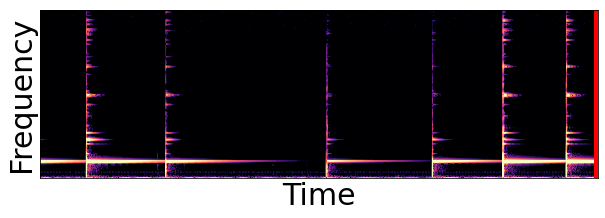

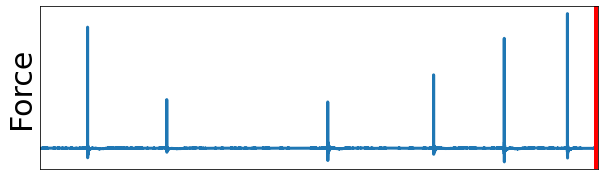

Synthesized 'ceramic'


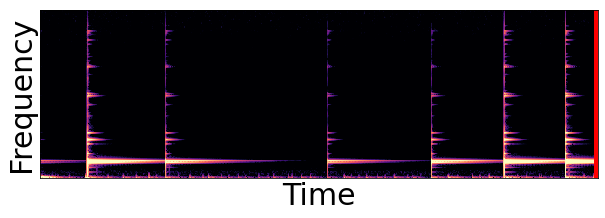

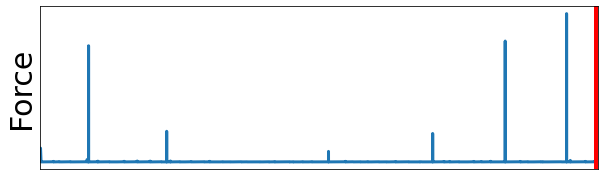

Real 'polycarb'


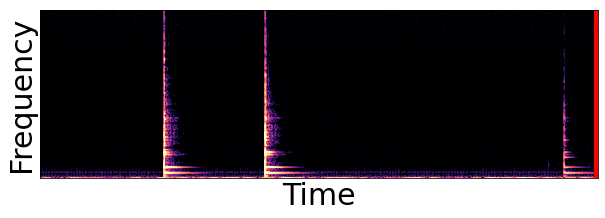

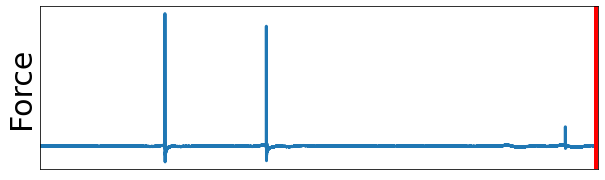

Synthesized 'polycarb'


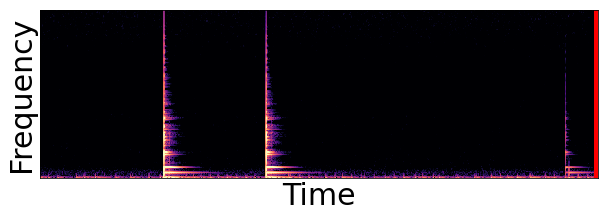

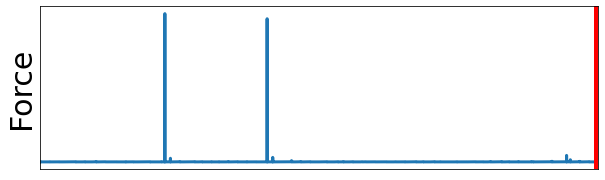

Real 'steel'


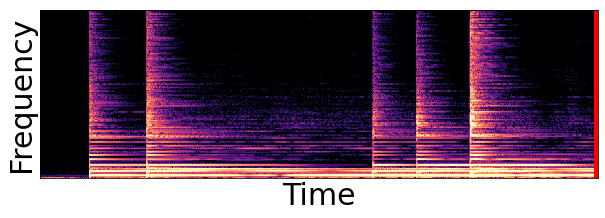

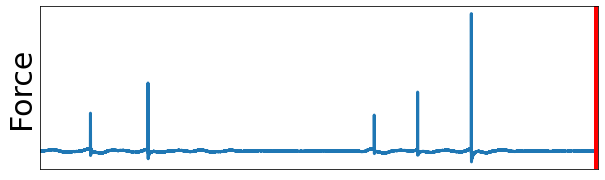

Synthesized 'steel'


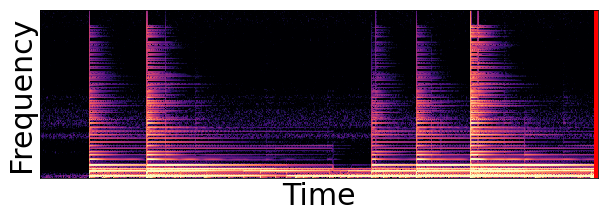

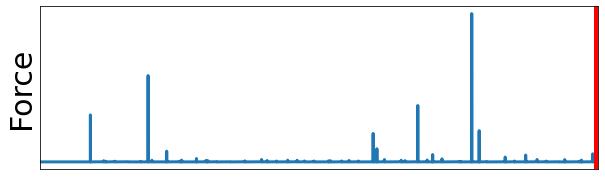

Real 'wood'


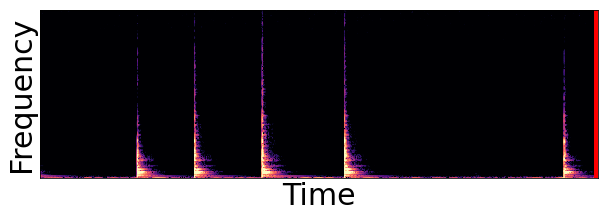

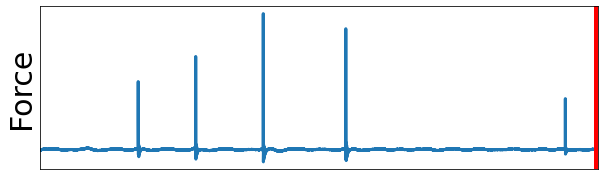

Synthesized 'wood'


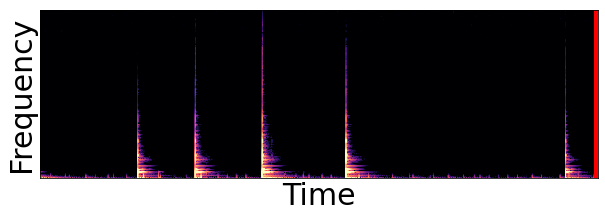

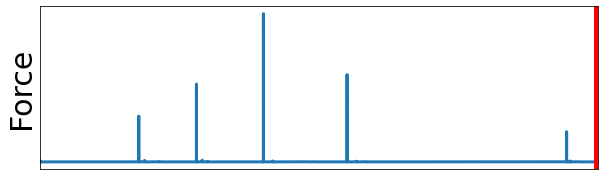

In [14]:
# Plot and animate spectrograms and impact force profiles for each recording
frame_rate = 60
figure_dir = os.path.join(output_dir, 'figures')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)
temp_dir = os.path.join(figure_dir, 'temp-images')
def clip_plots(in_clip, in_forces, prefix, xlabel, animate=False):
    num_seconds = in_clip.shape[0] / fs
    ddsp.colab.colab_utils.specplot(in_clip, size=512)
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)
    if not xlabel:
        plt.xlabel(' ')
    filename = os.path.join(figure_dir, '%s-spec'%prefix)
    fig.savefig('%s.png'%filename, bbox_inches='tight')
    if animate:
        os.mkdir(temp_dir)
        ax = plt.gca()
        line = ax.axvline(-0.5, lw=8, color='red')
        ylims = plt.ylim()
        xlims = plt.xlim()
        
        for i in range(int(num_seconds * frame_rate)):
            x_pos = xlims[0] + (i / (frame_rate * num_seconds - 1) * (xlims[1] - xlims[0]))
            line.set_data([x_pos, x_pos], ylims)
            fig.savefig(os.path.join(temp_dir, 'image%03i.png'%i), bbox_inches='tight')
        subprocess.check_output("ffmpeg -r %i -i %s.png -vcodec mpeg4 -y %s.mp4"%
                  (frame_rate, os.path.join(temp_dir,'image%03d'), filename), shell=True)
        shutil.rmtree(temp_dir)
        
    plt.show()
    
    plt.plot(in_forces / np.max(in_forces), linewidth=3)
    plt.ylabel('Force')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0, in_forces.shape[0])
    fig = plt.gcf()
    fig.set_size_inches(fig_width, fig_height)
    filename = os.path.join(figure_dir, '%s-force'%prefix)
    fig.savefig('%s.png'%filename, bbox_inches='tight')
    if animate:
        os.mkdir(temp_dir)
        ax = plt.gca()
        line = ax.axvline(-0.5, lw=8, color='red')
        ylims = plt.ylim()
        xlims = plt.xlim()
        
        for i in range(int(num_seconds * frame_rate)):
            x_pos = xlims[0] + (i / (frame_rate * num_seconds - 1) * (xlims[1] - xlims[0]))
            line.set_data([x_pos, x_pos], ylims)
            fig.savefig(os.path.join(temp_dir, 'image%03i.png'%i), bbox_inches='tight')
        subprocess.check_output("ffmpeg -r %i -i %s.png -vcodec mpeg4 -y %s.mp4"%
                  (frame_rate, os.path.join(temp_dir,'image%03d'), filename), shell=True)
        shutil.rmtree(temp_dir)
    plt.show()

for i in range(clips.shape[0]):
    print('Real \'%s\''%os.path.splitext(source_files[i])[0])
    clip_plots(real_audio[i, :], real_forces[i, :], 'real-%s'%os.path.splitext(source_files[i])[0], xlabel=True, animate=True)
    print('Synthesized \'%s\''%os.path.splitext(source_files[i])[0])
    clip_plots(synth_audio[i, :], synth_forces[i, :], 'synth-%s'%os.path.splitext(source_files[i])[0], xlabel=True, animate=True)